In [2]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

/Users/shirakawamomoko/Desktop/nlp100保存/.venv/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv("../chapter06/train.txt", sep='\t')
valid = pd.read_csv("../chapter06/valid.txt", sep='\t')
test = pd.read_csv("../chapter06/test.txt", sep='\t')

In [4]:
# max_lenを追加．トークン化されたシーケンスの最大長
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer, max_len):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = self.max_len,
            pad_to_max_length=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            "ids" : torch.LongTensor(ids),
            "mask" : torch.LongTensor(mask),
            "labels" : torch.Tensor(self.y[idx])
        }

In [6]:
#カテゴリをバイナリ表現にする準備
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

In [7]:
#BERTを使って分類タスクを行う
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, otuput_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')#事前学習済みBERTモデル
        self.drop = torch.nn.Dropout(drop_rate)#過学習を防ぐために一定のタイミングでニューロンを無効化する
        self.fc = torch.nn.Linear(768, otuput_size)#全結合層

    def forward(self, ids, mask, return_dict):
        _, out = self.bert(ids, attention_mask=mask,return_dict=return_dict)
        out = self.fc(self.drop(out))
        return out

In [8]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
          for data in loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, mask, return_dict=False)

            loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1).cpu().numpy() 
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total

In [9]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(ids, mask, return_dict=False)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [14]:
DROP_RATE = 0.4#ドロップアウト率，過学習を防ぐために使う
OUTPUT_SIZE = 4#分類(=カテゴリ)数
BATCH_SIZE = 16#バッチサイズ．一度に処理すつサンプル数．
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5#学習率．モデルのパタメータを更新するステップの大きさ(?)

model = BERTClass(DROP_RATE, OUTPUT_SIZE)
criterion = torch.nn.BCEWithLogitsLoss()#損失関数
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)#最適化アルゴリズム．
device = "mps"
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)
     

epoch: 1, loss_train: 0.0708, accuracy_train: 0.9597, loss_valid: 0.0958, accuracy_valid: 0.9393, 459.2335sec
epoch: 2, loss_train: 0.0477, accuracy_train: 0.9701, loss_valid: 0.0942, accuracy_valid: 0.9318, 398.9934sec
epoch: 3, loss_train: 0.0235, accuracy_train: 0.9887, loss_valid: 0.0907, accuracy_valid: 0.9415, 506.5199sec
epoch: 4, loss_train: 0.0191, accuracy_train: 0.9907, loss_valid: 0.1153, accuracy_valid: 0.9385, 569.7762sec


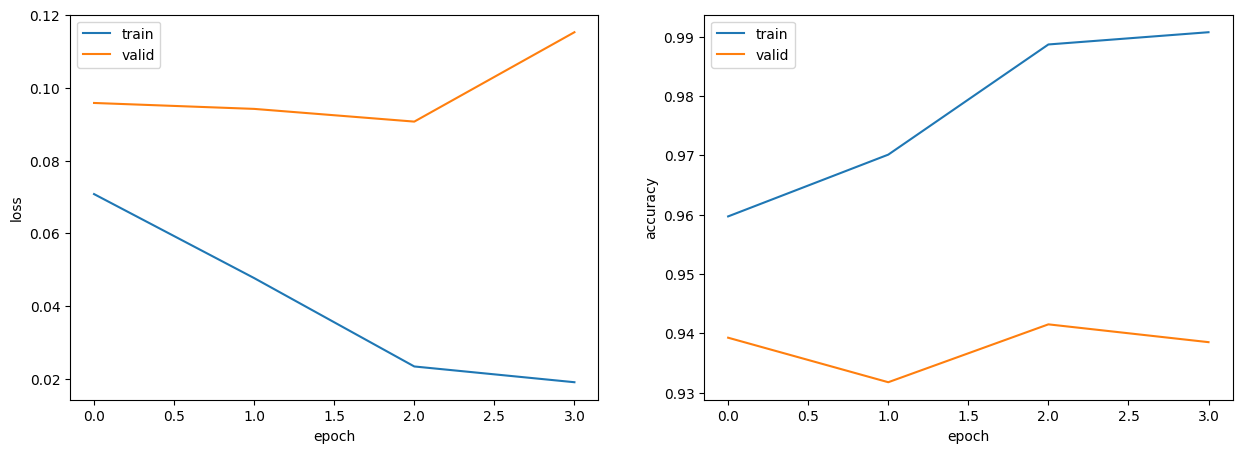

In [15]:
def make_graph_by_logs(log, savename):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig(savename)

make_graph_by_logs(log,  "./graphs/knock89.png")

In [16]:
def calculate_accuracy(model, dataset, device):
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model.forward(ids, mask, return_dict=False)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'Train正解率：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'Valid正解率：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'Test正解率：{calculate_accuracy(model, dataset_test, device):.3f}')

RuntimeError: MPS backend out of memory (MPS allocated: 8.64 GB, other allocations: 185.72 MB, max allowed: 9.07 GB). Tried to allocate 625.31 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).